# Noise field from street
(description)



### 0. Initialization
#### 0.1 Load required libraries

In [6]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
import scipy as sp

def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh


#### 0.2 Load the envelope as availability lattice

In [7]:
# loading the lattice from csv
lattice_path = os.path.relpath('../Data/dynamic output/voxelized_envelope.csv')
context_path = os.path.relpath('../data/raw data/immediate_context.obj')
avail_lattice = tg.lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)
context_mesh = tm.load(context_path)

#### 0.3 Load noise sources

In [8]:
# loading program from CSV
noise_source_path = os.path.relpath('../Data/raw data/Boekhorststraat_60dB.csv')
noise_sources = np.genfromtxt(noise_source_path, delimiter=',')

noise_sources[:,[1, 2]] = noise_sources[:,[2, 1]]
noise_sources[:, 1]  = noise_sources[:, 1]  * -1

noise_source_path1 = os.path.relpath('../Data/raw data/VanBokelweg_70dB.csv')
noise_sources1= np.genfromtxt(noise_source_path1, delimiter=',')

noise_sources1[:,[1, 2]] = noise_sources1[:,[2, 1]]
noise_sources1[:, 1]  = noise_sources1[:, 1]  * -1

noise_source_path2 = os.path.relpath('../Data/raw data/Schoterbosstraat_50dB.csv')
noise_sources2 = np.genfromtxt(noise_source_path2, delimiter=',')

noise_sources2[:,[1, 2]] = noise_sources2[:,[2, 1]]
noise_sources2[:, 1]  = noise_sources2[:, 1]  * -1

#### 0.4. Visualize noise source points

In [9]:
p = pv.Plotter(notebook=True)


# adding the avilability lattice
init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()

p.add_mesh(noise_sources, point_size=10)
p.add_mesh(noise_sources1, point_size=10)
p.add_mesh(noise_sources2, point_size=10)
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# p.show()

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x000001E686A0DFC0) at 0x000001E6967A14C0>

## 1. Creation noise field
#### 1.1 computing noise lattices

In [10]:
# create full lattice
full_lattice = avail_lattice * 0 + 1

# extract the coordinates of the centroid of all voxel
vox_centroids = full_lattice.centroids

# extract voxel indices of all voxels
vox_indices = np.array(np.where(full_lattice==1)).T

# setting the noise base pressure level 
noise_base = 60.0
noise_base1 = 70.0
noise_base2 = 50.0
# initializing the sum lattice of noise
sum_noise_lats = avail_lattice * 0.0

# for each source of noise
for noise_src in noise_sources:
    # initialize the occupation lattice
    dist_latice = avail_lattice * 0.0

    for cen, ind in zip(vox_centroids, vox_indices):
        # compute the euclidian distance
        dist_latice[tuple(ind)] = sp.spatial.distance.euclidean(cen, noise_src)

    # computing the noise lattice from dist lattice
    noise_latice = noise_base - 20 * np.log10(dist_latice) - 8
    
    # summing
    sum_noise_lats += np.power(10, noise_latice / 10.0)

# for each source of noise
for noise_src1 in noise_sources1:
    # initialize the occupation lattice
    dist_latice = avail_lattice * 0.0

    for cen, ind in zip(vox_centroids, vox_indices):
        # compute the euclidian distance
        dist_latice[tuple(ind)] = sp.spatial.distance.euclidean(cen, noise_src1)

    # computing the noise lattice from dist lattice
    noise_latice = noise_base1 - 20 * np.log10(dist_latice) - 8
    
    # summing
    sum_noise_lats += np.power(10, noise_latice / 10.0)

# for each source of noise
for noise_src2 in noise_sources2:
    # initialize the occupation lattice
    dist_latice = avail_lattice * 0.0

    for cen, ind in zip(vox_centroids, vox_indices):
        # compute the euclidian distance
        dist_latice[tuple(ind)] = sp.spatial.distance.euclidean(cen, noise_src2)

    # computing the noise lattice from dist lattice
    noise_latice = noise_base2 - 20 * np.log10(dist_latice) - 8
    
    # summing
    sum_noise_lats += np.power(10, noise_latice / 10.0)


# computing the final aggregation
agg_noise_lats = 10 * np.log10(sum_noise_lats)


#### 1.2. Visualizing the noise lattices

In [11]:
# initiating the plotter
p = pv.Plotter(notebook=True)

vis_lattice = agg_noise_lats

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = vis_lattice.shape
# The bottom left corner of the data set
grid.origin = vis_lattice.minbound
# These are the cell sizes along each axis
grid.spacing = vis_lattice.unit

# Add the data values to the cell data
grid.point_arrays["Noise"] = vis_lattice.flatten(order="F")  # Flatten the Lattice

    
# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6])*1.5
p.add_volume(grid, cmap="coolwarm" ,opacity=opacity, shade=True)
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

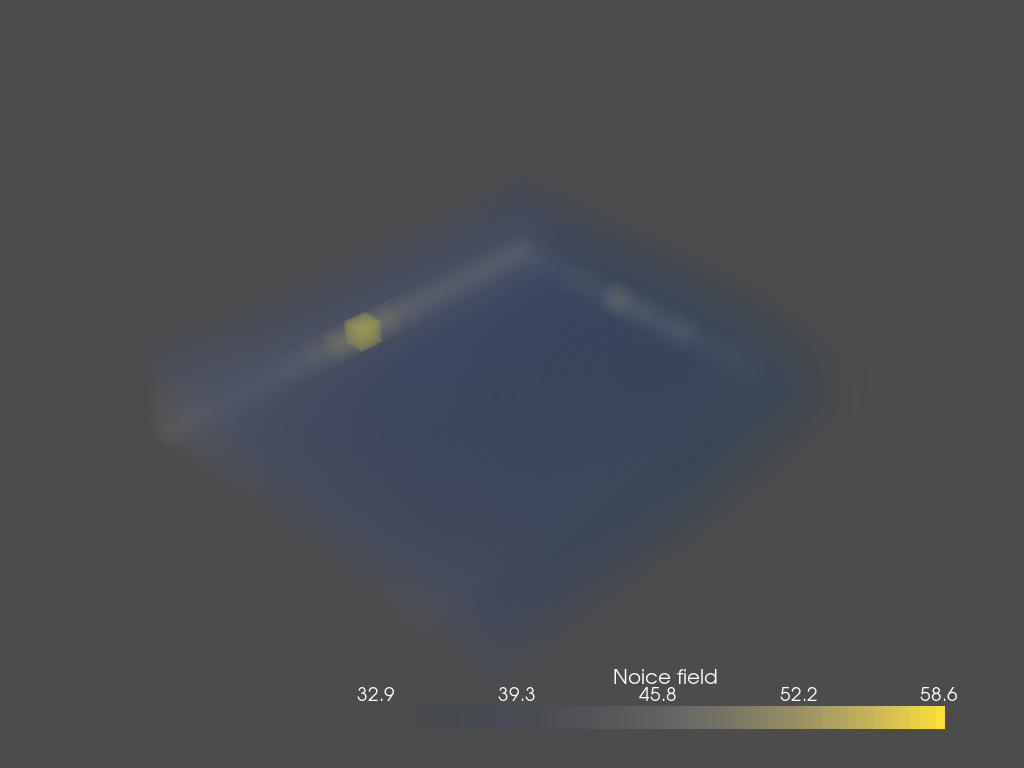

[(269.2590662461598, 192.75906624615982, 255.75906624615982),
 (31.5, -45.0, 18.0),
 (0.0, 0.0, 1.0)]

In [12]:
# initiating the plotter
p = pv.Plotter()

l = agg_noise_lats

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Noice field"] = l.flatten(order="F")  # Flatten the Lattice

# adding the volume
p.add_volume(grid, cmap="cividis", shade=False, show_scalar_bar=True)

# plotting
p.show()

#### Saving to csv

In [13]:
csv_path = os.path.relpath('../Data/dynamic output/noise_field.csv')
agg_noise_lats.to_csv(csv_path)

## Credits

In [14]:
__author__ = "Shervin Azadi"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on Noise Fields"